In [ ]:
# Import all packages
from google.colab import files               # Google Colab utility to upload/download files
import os                                     # Operating system interfaces
import glob                                   # File pattern matching
import math                                   # Math functions
import logging                                # Logging utility
import cv2                                    # OpenCV for image processing
import numpy as np                            # Numerical operations and arrays
from tqdm import tqdm                         # Progress bar for loops
import matplotlib.pyplot as plt               # Plotting library
from skimage.feature import hog               # Histogram of Oriented Gradients feature extractor
import collections                            # Container datatype for counting hashable objects
from sklearn.model_selection import train_test_split   # Train/test splitting
from sklearn.preprocessing import StandardScaler         # Feature scaling
from sklearn.linear_model import SGDClassifier           # Linear classifier with SGD optimizer
from sklearn.pipeline import make_pipeline                # Pipeline for chaining preprocessing and classifier
from sklearn.metrics import classification_report          # Classification metrics and reports
import seaborn as sns                          # Statistical data visualization
import pandas as pd                            # Data manipulation and analysis
from sklearn.metrics import confusion_matrix  # Confusion matrix calculation
from sklearn.metrics import RocCurveDisplay   # ROC curve plotting
from google.colab.patches import cv2_imshow   # Colab utility for displaying OpenCV images inline

In [ ]:
# Upload the Kaggle API key file (kaggle.json)
print("Upload the kaggle.json file you downloaded from your Kaggle account.")
files.upload()  # Opens a file upload dialog to upload kaggle.json

# Create the .kaggle directory if it doesn't exist
# Move the uploaded kaggle.json into that directory
# Set the correct permissions so Kaggle CLI can access it
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the FDDB dataset using the Kaggle CLI
# The dataset will be downloaded as a zip file
!kaggle datasets download -d cormacwc/fddb-dataset

# Create a directory to extract the dataset into
# Then unzip the downloaded dataset into that directory
!mkdir -p fddb_data
!unzip -q fddb-dataset.zip -d fddb_data

# List and print the contents of the 'fddb_data' folder
print("\n Contents of the fddb_data folder:")
print(os.listdir("fddb_data"))

# Walk through the 'fddb_data' directory and print subdirectories (one level deep)
print("\n Subdirectories available:")
for root, dirs, files in os.walk("fddb_data"):
    for name in dirs:
        print("🔹", os.path.join(root, name))
    break  # Only look at the top-level subdirectories

Upload the kaggle.json file you downloaded from your Kaggle account.


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/cormacwc/fddb-dataset
License(s): unknown
 99% 516M/523M [00:01<00:00, 344MB/s]
100% 523M/523M [00:01<00:00, 347MB/s]

 Contents of the fddb_data folder:
['FDDB copy']

 Subdirectories available:
🔹 fddb_data/FDDB copy


##**Project Overview:**
The ProCam project aims to develop a compact digital camera with an automatic face detection system built from scratch using Scikit-learn, without pre-trained models. The system must detect faces in images and output bounding boxes for each face.

##**Dataset Choice:**
The FDDB (Face Detection Data Set and Benchmark) was selected because it contains:
- 2,845 real-world images with 5,171 annotated faces
- Publicly available, suitable for prototyping
- Annotations in elliptical format, requiring conversion to bounding boxes

##**Dataset Download Process:**
- Obtained Kaggle API credentials (kaggle.json) and uploaded them in Colab
- Created and configured the ~/.kaggle directory with proper permissions
- Downloaded the FDDB dataset using Kaggle CLI
- Extracted dataset files into the working directory

##**Dataset Content and Format:**
- Images: Real-life photos with varied face positions and lighting
- Annotations: Face locations given as ellipses (center, axes, orientation)
- Annotation format differs from common datasets, requiring conversion to rectangular bounding boxes

##**Considerations:**
- Annotation Conversion: Elliptical annotations must be converted into bounding boxes compatible with Scikit-learn
- Dataset Imbalance: FDDB has no images without faces, so negative samples need to be added.
- Resource Limits: Images may be resized and feature extraction optimized to train efficient models.

##**Summary and Next Steps:**
- Kaggle API successfully configured, dataset downloaded and extracted
- Explored dataset structure and annotation format
- Next steps:
  1. Parse and convert ellipse annotations to bounding boxes
  2. Collect negative samples for balanced training
  3. Extract features suitable for Scikit-learn
  4. Train and evaluate face detection models optimized for limited resources

In [ ]:
# Walk through the directory tree starting at "fddb_data/FDDB copy"
# os.walk() yields a 3-tuple (root, dirs, files) for each directory in the tree
for root, dirs, files in os.walk("fddb_data/FDDB copy"):

    # Print the current folder path
    print(f"📁 Folder: {root}")

    # Print the first 5 files in the current folder (to avoid flooding output)
    for name in files[:5]:
        print("  📄", name)

    # If the current folder has no subdirectories (leaf folder), stop the loop after the first one
    if not dirs:
        break

📁 Folder: fddb_data/FDDB copy
📁 Folder: fddb_data/FDDB copy/FDDB-folds
  📄 FDDB-fold-06.txt
  📄 FDDB-fold-10.txt
  📄 FDDB-fold-01-ellipseList.csv
  📄 FDDB-fold-02-ellipseList.txt
  📄 FDDB-fold-07.txt


##**Explanation of the Directory Walk Code:**
The code iterates through the folder tree starting at "fddb_data/FDDB copy" using Python’s os.walk(). This function returns a tuple for each directory it visits, containing:
- root: the current folder path
- dirs: a list of subdirectories inside root
- files: a list of files inside root

The loop prints:
- The current folder path, to understand the folder structure
- The names of up to five files in each folder, to avoid too much output while still inspecting sample contents

If the code reaches a folder without any subdirectories (a “leaf” folder), it stops further traversal to limit the output to the top-level and one leaf folder only.

This exploration step helps verify the dataset’s organization, identifying where images and annotation files are located before moving on to data processing.

In [ ]:
# Setup basic logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

def ellipse_to_bbox(major_axis_radius, minor_axis_radius, angle, center_x, center_y):
    """
    Convert an ellipse annotation to a tight axis-aligned bounding box considering rotation.
    The bounding box is computed by finding the rotated ellipse corner points.
    """
    # Convert angle to radians
    theta = angle

    # Define four extreme points of the ellipse in its local coordinate system
    points = [
        (major_axis_radius, 0),
        (-major_axis_radius, 0),
        (0, minor_axis_radius),
        (0, -minor_axis_radius)
    ]

    # Rotate each point and translate it to the center
    rotated_points = []
    for x, y in points:
        x_rot = x * math.cos(theta) - y * math.sin(theta) + center_x
        y_rot = x * math.sin(theta) + y * math.cos(theta) + center_y
        rotated_points.append((x_rot, y_rot))

    # Calculate axis-aligned bounding box from rotated points
    xs, ys = zip(*rotated_points)
    x_min, x_max = min(xs), max(xs)
    y_min, y_max = min(ys), max(ys)

    width = x_max - x_min
    height = y_max - y_min

    return [int(x_min), int(y_min), int(width), int(height)]

def parse_fddb_single_annotation_file(annotation_file):
    """
    Parse a single FDDB annotation file in ellipseList format.
    Returns a list of dictionaries, each containing the normalized image path and bounding boxes.
    """
    annotations = []

    with open(annotation_file, 'r') as f:
        lines = iter(f.read().splitlines())

    try:
        while True:
            image_path = next(lines).strip()
            n_faces_line = next(lines).strip()

            # Validate number of faces
            if not n_faces_line.isdigit():
                logging.warning(f"Invalid number of faces '{n_faces_line}' in file {annotation_file}")
                continue
            n_faces = int(n_faces_line)
            if n_faces < 0:
                logging.warning(f"Negative face count {n_faces} in file {annotation_file}")
                continue

            bboxes = []
            for _ in range(n_faces):
                line = next(lines).strip()
                parts = line.split()
                if len(parts) < 5:
                    logging.warning(f"Malformed annotation line: '{line}' in file {annotation_file}")
                    continue

                try:
                    major, minor, angle, center_x, center_y = map(float, parts[:5])
                except ValueError:
                    logging.warning(f"Invalid ellipse parameters in line: '{line}' in file {annotation_file}")
                    continue

                bbox = ellipse_to_bbox(major, minor, angle, center_x, center_y)
                bboxes.append(bbox)

            # Normalize image path for cross-platform compatibility
            norm_image_path = os.path.normpath(image_path + ".jpg")
            annotations.append({
                "image_path": norm_image_path,
                "bboxes": bboxes
            })
    except StopIteration:
        # End of file reached normally
        pass

    return annotations

def parse_all_fddb_annotation_files(annotation_folder):
    """
    Parse all FDDB ellipse annotation files in the specified folder.
    """
    all_annotations = []
    annotation_files = glob.glob(os.path.join(annotation_folder, "*-ellipseList.txt"))

    if not annotation_files:
        logging.warning(f"No annotation files found in folder: {annotation_folder}")

    for file_path in annotation_files:
        logging.info(f"Parsing annotation file: {file_path}")
        annotations = parse_fddb_single_annotation_file(file_path)
        all_annotations.extend(annotations)

    return all_annotations

# Example usage
annotation_folder = "fddb_data/FDDB copy/FDDB-folds"
annotations = parse_all_fddb_annotation_files(annotation_folder)

logging.info(f"Parsed {len(annotations)} images with annotations.")

# Display first 3 annotations for verification
for ann in annotations[:3]:
    print(f"Image: {ann['image_path']}")
    print(f"Bounding Boxes: {ann['bboxes']}\n")

Image: 2002/07/28/big/img_416.jpg
Bounding Boxes: [[53, 21, 88, 121], [285, 11, 71, 104], [346, 79, 36, 47]]

Image: 2002/08/07/big/img_1393.jpg
Bounding Boxes: [[29, 17, 206, 309], [111, 143, 185, 256]]

Image: 2002/08/26/big/img_292.jpg
Bounding Boxes: [[47, 18, 202, 327]]



##**Code Overview**
###**ellipse_to_bbox function:**
- Converts ellipse parameters — major axis radius, minor axis radius, rotation angle (in radians), and center coordinates — into an approximate axis-aligned bounding box
- It calculates the four extreme points of the ellipse (before rotation), rotates them according to the given angle, and finds the minimum and maximum x and y coordinates of these rotated points.
- Returns a bounding box [x_min, y_min, width, height] that tightly encloses the rotated ellipse

###**parse_fddb_single_annotation_file function:**
- Reads a single FDDB annotation file in the ellipseList format
- The file structure is:
  1. First line: relative image path (without extension)
  2. Second line: number of faces in the image
  3. Next n lines: ellipse parameters for each face (major radius, minor radius, angle, center x, center y)
- Converts each ellipse to a bounding box using ellipse_to_bbox
- Normalizes the image path by adding .jpg extension and adjusting path separators for the OS
- Returns a list of dictionaries, each containing:
  1. "image_path": normalized image filename
  2. "bboxes": list of bounding boxes for faces in that image
- Uses logging to warn about any malformed lines or invalid data.

###**parse_all_fddb_annotation_files function:**
- Searches the specified annotation folder for all files matching the pattern *-ellipseList.txt
- Parses each annotation file with parse_fddb_single_annotation_file
- Aggregates all parsed annotations into a single list
- Logs warnings if no annotation files are found

###**Output:**
- After parsing, logs how many images with annotations were parsed
- Prints the first 3 entries showing the image path and corresponding bounding boxes to verify correct parsing

In [ ]:
# STEP 1 - CONFIGURATION AND PATCH EXTRACTION
# Configuration
IMG_BASE_PATH = "fddb_data/FDDB copy/originalPics"
PATCH_SIZE = (64, 64)
MIN_PATCH_SIZE = 20  # Minimum acceptable patch size before resizing
NEG_SAMPLES_PER_IMAGE = 10
MAX_NEGATIVE_ATTEMPTS = 10  # Max attempts for negative patches

# Lists for positive and negative patches
positive_patches = []
negative_patches = []

def boxes_overlap(box1, box2):
    """
    Check if two boxes overlap.
    box = [x, y, width, height]
    """
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    return not (x1 + w1 <= x2 or x2 + w2 <= x1 or y1 + h1 <= y2 or y2 + h2 <= y1)

# Iterate annotations
for ann in tqdm(annotations, desc="Extracting patches"):

    img_path = os.path.join(IMG_BASE_PATH, ann['image_path'])
    if not os.path.exists(img_path):
        # File not found, skip
        continue

    img = cv2.imread(img_path)
    if img is None:
        continue

    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    h, w = img_gray.shape

    face_boxes = np.array(ann['bboxes'])

    # --- Positive patches ---
    for (x, y, bw, bh) in ann['bboxes']:
        x1 = max(0, x)
        y1 = max(0, y)
        x2 = min(w, x + bw)
        y2 = min(h, y + bh)

        face_patch = img_gray[y1:y2, x1:x2]

        # Minimum size check for positive patches
        face_h, face_w = face_patch.shape
        if face_w < MIN_PATCH_SIZE or face_h < MIN_PATCH_SIZE or face_patch.size == 0:
            continue

        # Resize patch
        face_patch = cv2.resize(face_patch, PATCH_SIZE)

        positive_patches.append(face_patch)

    # --- Negative patches ---
    neg_patches_extracted = 0
    attempts_total = 0

    while neg_patches_extracted < NEG_SAMPLES_PER_IMAGE and attempts_total < NEG_SAMPLES_PER_IMAGE * MAX_NEGATIVE_ATTEMPTS:
        attempts_total += 1
        nx = np.random.randint(0, w - PATCH_SIZE[0])
        ny = np.random.randint(0, h - PATCH_SIZE[1])
        proposed_box = [nx, ny, PATCH_SIZE[0], PATCH_SIZE[1]]

        # Check overlap with all faces
        overlaps = any(boxes_overlap(proposed_box, fb) for fb in face_boxes)

        if not overlaps:
            nonface_patch = img_gray[ny:ny + PATCH_SIZE[1], nx:nx + PATCH_SIZE[0]]
            if nonface_patch.size == 0:
                continue  # empty patch, ignore

            negative_patches.append(nonface_patch)
            neg_patches_extracted += 1

    if neg_patches_extracted < NEG_SAMPLES_PER_IMAGE:
        print(f"⚠️ Warning: Only extracted {neg_patches_extracted} negative patches for image {ann['image_path']} (requested {NEG_SAMPLES_PER_IMAGE})")

print(f"\nExtraction complete: {len(positive_patches)} positive patches, {len(negative_patches)} negative patches.")

Extracting patches:   2%|▏         | 48/2845 [00:00<00:10, 255.85it/s]

⚠️ Warning: Only extracted 9 negative patches for image 2002/08/07/big/img_1393.jpg (requested 10)
⚠️ Warning: Only extracted 9 negative patches for image 2002/08/26/big/img_292.jpg (requested 10)
⚠️ Warning: Only extracted 3 negative patches for image 2002/08/26/big/img_301.jpg (requested 10)
⚠️ Warning: Only extracted 6 negative patches for image 2003/01/14/big/img_891.jpg (requested 10)


Extracting patches:   4%|▍         | 120/2845 [00:00<00:08, 321.19it/s]

⚠️ Warning: Only extracted 2 negative patches for image 2002/07/23/big/img_404.jpg (requested 10)
⚠️ Warning: Only extracted 8 negative patches for image 2002/08/10/big/img_404.jpg (requested 10)
⚠️ Warning: Only extracted 9 negative patches for image 2002/08/22/big/img_612.jpg (requested 10)
⚠️ Warning: Only extracted 4 negative patches for image 2003/01/14/big/img_837.jpg (requested 10)
⚠️ Warning: Only extracted 3 negative patches for image 2002/07/19/big/img_930.jpg (requested 10)
⚠️ Warning: Only extracted 0 negative patches for image 2002/08/30/big/img_18470.jpg (requested 10)
⚠️ Warning: Only extracted 8 negative patches for image 2002/08/19/big/img_353.jpg (requested 10)
⚠️ Warning: Only extracted 3 negative patches for image 2002/08/02/big/img_275.jpg (requested 10)
⚠️ Warning: Only extracted 2 negative patches for image 2002/08/20/big/img_579.jpg (requested 10)


Extracting patches:   7%|▋         | 193/2845 [00:00<00:07, 346.32it/s]

⚠️ Warning: Only extracted 9 negative patches for image 2003/01/01/big/img_458.jpg (requested 10)
⚠️ Warning: Only extracted 8 negative patches for image 2003/01/13/big/img_576.jpg (requested 10)
⚠️ Warning: Only extracted 9 negative patches for image 2003/01/17/big/img_17.jpg (requested 10)
⚠️ Warning: Only extracted 6 negative patches for image 2002/07/23/big/img_750.jpg (requested 10)
⚠️ Warning: Only extracted 6 negative patches for image 2002/07/25/big/img_135.jpg (requested 10)


Extracting patches:   9%|▉         | 262/2845 [00:00<00:08, 319.78it/s]

⚠️ Warning: Only extracted 4 negative patches for image 2002/08/24/big/img_386.jpg (requested 10)
⚠️ Warning: Only extracted 8 negative patches for image 2002/07/25/big/img_887.jpg (requested 10)
⚠️ Warning: Only extracted 4 negative patches for image 2002/08/10/big/img_520.jpg (requested 10)
⚠️ Warning: Only extracted 0 negative patches for image 2002/08/25/big/img_705.jpg (requested 10)
⚠️ Warning: Only extracted 2 negative patches for image 2002/08/04/big/img_727.jpg (requested 10)


Extracting patches:  12%|█▏        | 334/2845 [00:01<00:07, 338.03it/s]

⚠️ Warning: Only extracted 3 negative patches for image 2002/07/31/big/img_232.jpg (requested 10)
⚠️ Warning: Only extracted 9 negative patches for image 2002/07/29/big/img_246.jpg (requested 10)
⚠️ Warning: Only extracted 0 negative patches for image 2002/08/20/big/img_872.jpg (requested 10)
⚠️ Warning: Only extracted 0 negative patches for image 2003/01/16/big/img_1040.jpg (requested 10)
⚠️ Warning: Only extracted 8 negative patches for image 2002/07/22/big/img_445.jpg (requested 10)
⚠️ Warning: Only extracted 3 negative patches for image 2002/08/20/big/img_407.jpg (requested 10)


Extracting patches:  16%|█▌        | 458/2845 [00:01<00:06, 381.59it/s]

⚠️ Warning: Only extracted 1 negative patches for image 2002/08/18/big/img_603.jpg (requested 10)
⚠️ Warning: Only extracted 4 negative patches for image 2002/08/24/big/img_662.jpg (requested 10)
⚠️ Warning: Only extracted 0 negative patches for image 2002/08/18/big/img_660.jpg (requested 10)
⚠️ Warning: Only extracted 4 negative patches for image 2003/01/16/big/img_40.jpg (requested 10)
⚠️ Warning: Only extracted 5 negative patches for image 2002/07/25/big/img_491.jpg (requested 10)
⚠️ Warning: Only extracted 9 negative patches for image 2002/08/03/big/img_654.jpg (requested 10)


Extracting patches:  22%|██▏       | 613/2845 [00:01<00:04, 467.43it/s]

⚠️ Warning: Only extracted 0 negative patches for image 2002/08/08/big/img_607.jpg (requested 10)
⚠️ Warning: Only extracted 3 negative patches for image 2002/07/30/big/img_847.jpg (requested 10)
⚠️ Warning: Only extracted 8 negative patches for image 2002/07/31/big/img_374.jpg (requested 10)
⚠️ Warning: Only extracted 7 negative patches for image 2002/08/19/big/img_229.jpg (requested 10)
⚠️ Warning: Only extracted 1 negative patches for image 2002/08/06/big/img_2535.jpg (requested 10)
⚠️ Warning: Only extracted 8 negative patches for image 2003/01/17/big/img_24.jpg (requested 10)
⚠️ Warning: Only extracted 0 negative patches for image 2002/07/30/big/img_571.jpg (requested 10)
⚠️ Warning: Only extracted 0 negative patches for image 2002/07/25/big/img_478.jpg (requested 10)
⚠️ Warning: Only extracted 5 negative patches for image 2002/07/19/big/img_230.jpg (requested 10)
⚠️ Warning: Only extracted 0 negative patches for image 2003/01/16/big/img_627.jpg (requested 10)


Extracting patches:  25%|██▍       | 709/2845 [00:01<00:04, 461.03it/s]

⚠️ Warning: Only extracted 0 negative patches for image 2002/08/31/big/img_18074.jpg (requested 10)
⚠️ Warning: Only extracted 1 negative patches for image 2003/01/17/big/img_509.jpg (requested 10)
⚠️ Warning: Only extracted 0 negative patches for image 2002/08/10/big/img_598.jpg (requested 10)
⚠️ Warning: Only extracted 2 negative patches for image 2002/08/05/big/img_3371.jpg (requested 10)
⚠️ Warning: Only extracted 6 negative patches for image 2002/07/31/big/img_741.jpg (requested 10)
⚠️ Warning: Only extracted 5 negative patches for image 2003/01/01/big/img_327.jpg (requested 10)
⚠️ Warning: Only extracted 1 negative patches for image 2002/07/23/big/img_261.jpg (requested 10)
⚠️ Warning: Only extracted 8 negative patches for image 2002/07/20/big/img_588.jpg (requested 10)
⚠️ Warning: Only extracted 7 negative patches for image 2002/08/14/big/img_1046.jpg (requested 10)


Extracting patches:  29%|██▊       | 817/2845 [00:02<00:04, 496.94it/s]

⚠️ Warning: Only extracted 3 negative patches for image 2002/07/27/big/img_735.jpg (requested 10)
⚠️ Warning: Only extracted 2 negative patches for image 2002/07/29/big/img_1316.jpg (requested 10)
⚠️ Warning: Only extracted 6 negative patches for image 2002/08/29/big/img_19075.jpg (requested 10)


Extracting patches:  32%|███▏      | 916/2845 [00:02<00:04, 477.29it/s]

⚠️ Warning: Only extracted 9 negative patches for image 2002/08/23/big/img_407.jpg (requested 10)
⚠️ Warning: Only extracted 5 negative patches for image 2002/07/25/big/img_891.jpg (requested 10)
⚠️ Warning: Only extracted 0 negative patches for image 2002/09/02/big/img_15153.jpg (requested 10)
⚠️ Warning: Only extracted 1 negative patches for image 2002/08/26/big/img_465.jpg (requested 10)
⚠️ Warning: Only extracted 0 negative patches for image 2002/07/31/big/img_658.jpg (requested 10)
⚠️ Warning: Only extracted 0 negative patches for image 2002/07/23/big/img_423.jpg (requested 10)
⚠️ Warning: Only extracted 6 negative patches for image 2002/07/29/big/img_457.jpg (requested 10)
⚠️ Warning: Only extracted 0 negative patches for image 2002/08/01/big/img_1470.jpg (requested 10)


Extracting patches:  38%|███▊      | 1072/2845 [00:02<00:03, 496.76it/s]

⚠️ Warning: Only extracted 2 negative patches for image 2002/07/30/big/img_1019.jpg (requested 10)
⚠️ Warning: Only extracted 0 negative patches for image 2002/08/05/big/img_3752.jpg (requested 10)
⚠️ Warning: Only extracted 2 negative patches for image 2002/07/25/big/img_618.jpg (requested 10)
⚠️ Warning: Only extracted 0 negative patches for image 2002/08/02/big/img_545.jpg (requested 10)
⚠️ Warning: Only extracted 6 negative patches for image 2002/07/24/big/img_554.jpg (requested 10)
⚠️ Warning: Only extracted 4 negative patches for image 2002/07/22/big/img_766.jpg (requested 10)
⚠️ Warning: Only extracted 3 negative patches for image 2002/07/21/big/img_608.jpg (requested 10)
⚠️ Warning: Only extracted 9 negative patches for image 2002/08/06/big/img_2826.jpg (requested 10)
⚠️ Warning: Only extracted 0 negative patches for image 2002/07/31/big/img_229.jpg (requested 10)
⚠️ Warning: Only extracted 0 negative patches for image 2002/07/22/big/img_602.jpg (requested 10)
⚠️ Warning: Only 

Extracting patches:  45%|████▍     | 1275/2845 [00:03<00:03, 492.62it/s]

⚠️ Warning: Only extracted 8 negative patches for image 2002/07/30/big/img_606.jpg (requested 10)
⚠️ Warning: Only extracted 6 negative patches for image 2003/01/14/big/img_925.jpg (requested 10)
⚠️ Warning: Only extracted 9 negative patches for image 2002/08/26/big/img_264.jpg (requested 10)
⚠️ Warning: Only extracted 0 negative patches for image 2002/08/25/big/img_277.jpg (requested 10)
⚠️ Warning: Only extracted 0 negative patches for image 2003/01/14/big/img_937.jpg (requested 10)
⚠️ Warning: Only extracted 7 negative patches for image 2002/08/21/big/img_254.jpg (requested 10)
⚠️ Warning: Only extracted 7 negative patches for image 2002/09/01/big/img_16776.jpg (requested 10)
⚠️ Warning: Only extracted 5 negative patches for image 2002/08/21/big/img_713.jpg (requested 10)


Extracting patches:  48%|████▊     | 1375/2845 [00:03<00:03, 483.37it/s]

⚠️ Warning: Only extracted 0 negative patches for image 2002/08/05/big/img_3523.jpg (requested 10)
⚠️ Warning: Only extracted 8 negative patches for image 2002/07/29/big/img_218.jpg (requested 10)
⚠️ Warning: Only extracted 4 negative patches for image 2002/08/09/big/img_839.jpg (requested 10)
⚠️ Warning: Only extracted 8 negative patches for image 2002/08/19/big/img_117.jpg (requested 10)
⚠️ Warning: Only extracted 2 negative patches for image 2003/01/01/big/img_158.jpg (requested 10)
⚠️ Warning: Only extracted 2 negative patches for image 2002/08/12/big/img_630.jpg (requested 10)
⚠️ Warning: Only extracted 4 negative patches for image 2002/07/22/big/img_542.jpg (requested 10)


Extracting patches:  52%|█████▏    | 1485/2845 [00:03<00:02, 514.56it/s]

⚠️ Warning: Only extracted 4 negative patches for image 2002/08/01/big/img_1656.jpg (requested 10)
⚠️ Warning: Only extracted 7 negative patches for image 2002/08/03/big/img_542.jpg (requested 10)
⚠️ Warning: Only extracted 4 negative patches for image 2002/07/23/big/img_360.jpg (requested 10)
⚠️ Warning: Only extracted 9 negative patches for image 2002/08/20/big/img_375.jpg (requested 10)
⚠️ Warning: Only extracted 9 negative patches for image 2002/08/12/big/img_130.jpg (requested 10)
⚠️ Warning: Only extracted 8 negative patches for image 2002/07/23/big/img_477.jpg (requested 10)
⚠️ Warning: Only extracted 0 negative patches for image 2002/08/06/big/img_2660.jpg (requested 10)
⚠️ Warning: Only extracted 1 negative patches for image 2002/08/10/big/img_569.jpg (requested 10)
⚠️ Warning: Only extracted 0 negative patches for image 2002/07/28/big/img_493.jpg (requested 10)
⚠️ Warning: Only extracted 6 negative patches for image 2002/09/01/big/img_16880.jpg (requested 10)
⚠️ Warning: Only

Extracting patches:  58%|█████▊    | 1644/2845 [00:03<00:02, 519.19it/s]

⚠️ Warning: Only extracted 0 negative patches for image 2003/01/17/big/img_417.jpg (requested 10)
⚠️ Warning: Only extracted 2 negative patches for image 2002/08/23/big/img_785.jpg (requested 10)
⚠️ Warning: Only extracted 9 negative patches for image 2002/08/07/big/img_1156.jpg (requested 10)
⚠️ Warning: Only extracted 5 negative patches for image 2002/08/23/big/img_378.jpg (requested 10)
⚠️ Warning: Only extracted 9 negative patches for image 2003/01/17/big/img_943.jpg (requested 10)
⚠️ Warning: Only extracted 9 negative patches for image 2002/07/22/big/img_663.jpg (requested 10)
⚠️ Warning: Only extracted 3 negative patches for image 2002/07/24/big/img_789.jpg (requested 10)
⚠️ Warning: Only extracted 8 negative patches for image 2002/07/22/big/img_548.jpg (requested 10)
⚠️ Warning: Only extracted 2 negative patches for image 2002/08/22/big/img_344.jpg (requested 10)


Extracting patches:  61%|██████▏   | 1747/2845 [00:03<00:02, 501.02it/s]

⚠️ Warning: Only extracted 0 negative patches for image 2002/07/24/big/img_834.jpg (requested 10)
⚠️ Warning: Only extracted 5 negative patches for image 2002/07/25/big/img_725.jpg (requested 10)
⚠️ Warning: Only extracted 1 negative patches for image 2003/01/01/big/img_475.jpg (requested 10)
⚠️ Warning: Only extracted 0 negative patches for image 2002/07/25/big/img_836.jpg (requested 10)
⚠️ Warning: Only extracted 0 negative patches for image 2002/08/15/big/img_877.jpg (requested 10)
⚠️ Warning: Only extracted 7 negative patches for image 2002/07/25/big/img_778.jpg (requested 10)


Extracting patches:  65%|██████▌   | 1851/2845 [00:04<00:01, 507.53it/s]

⚠️ Warning: Only extracted 1 negative patches for image 2002/07/27/big/img_543.jpg (requested 10)
⚠️ Warning: Only extracted 5 negative patches for image 2002/08/26/big/img_674.jpg (requested 10)
⚠️ Warning: Only extracted 6 negative patches for image 2003/01/15/big/img_1183.jpg (requested 10)
⚠️ Warning: Only extracted 0 negative patches for image 2002/07/26/big/img_518.jpg (requested 10)
⚠️ Warning: Only extracted 0 negative patches for image 2002/07/22/big/img_839.jpg (requested 10)
⚠️ Warning: Only extracted 6 negative patches for image 2002/08/02/big/img_1105.jpg (requested 10)
⚠️ Warning: Only extracted 8 negative patches for image 2002/07/25/big/img_138.jpg (requested 10)
⚠️ Warning: Only extracted 9 negative patches for image 2002/07/19/big/img_352.jpg (requested 10)
⚠️ Warning: Only extracted 0 negative patches for image 2002/08/21/big/img_638.jpg (requested 10)
⚠️ Warning: Only extracted 2 negative patches for image 2002/08/01/big/img_2087.jpg (requested 10)


Extracting patches:  69%|██████▉   | 1957/2845 [00:04<00:01, 518.70it/s]

⚠️ Warning: Only extracted 0 negative patches for image 2002/08/17/big/img_818.jpg (requested 10)
⚠️ Warning: Only extracted 0 negative patches for image 2002/07/23/big/img_340.jpg (requested 10)
⚠️ Warning: Only extracted 0 negative patches for image 2002/08/10/big/img_783.jpg (requested 10)
⚠️ Warning: Only extracted 0 negative patches for image 2002/08/08/big/img_254.jpg (requested 10)
⚠️ Warning: Only extracted 9 negative patches for image 2002/07/24/big/img_511.jpg (requested 10)
⚠️ Warning: Only extracted 2 negative patches for image 2002/07/22/big/img_769.jpg (requested 10)
⚠️ Warning: Only extracted 1 negative patches for image 2002/08/01/big/img_1692.jpg (requested 10)


Extracting patches:  72%|███████▏  | 2061/2845 [00:04<00:01, 509.54it/s]

⚠️ Warning: Only extracted 8 negative patches for image 2002/07/26/big/img_232.jpg (requested 10)
⚠️ Warning: Only extracted 4 negative patches for image 2002/07/21/big/img_76.jpg (requested 10)
⚠️ Warning: Only extracted 8 negative patches for image 2002/08/12/big/img_740.jpg (requested 10)
⚠️ Warning: Only extracted 0 negative patches for image 2002/07/30/big/img_852.jpg (requested 10)
⚠️ Warning: Only extracted 5 negative patches for image 2002/08/19/big/img_125.jpg (requested 10)
⚠️ Warning: Only extracted 6 negative patches for image 2002/08/18/big/img_183.jpg (requested 10)
⚠️ Warning: Only extracted 5 negative patches for image 2002/07/23/big/img_138.jpg (requested 10)
⚠️ Warning: Only extracted 3 negative patches for image 2002/07/25/big/img_355.jpg (requested 10)
⚠️ Warning: Only extracted 7 negative patches for image 2002/08/21/big/img_465.jpg (requested 10)


Extracting patches:  76%|███████▌  | 2165/2845 [00:04<00:01, 475.47it/s]

⚠️ Warning: Only extracted 0 negative patches for image 2002/08/01/big/img_1345.jpg (requested 10)
⚠️ Warning: Only extracted 3 negative patches for image 2002/08/07/big/img_1448.jpg (requested 10)
⚠️ Warning: Only extracted 3 negative patches for image 2002/08/31/big/img_17967.jpg (requested 10)
⚠️ Warning: Only extracted 9 negative patches for image 2002/08/16/big/img_652.jpg (requested 10)
⚠️ Warning: Only extracted 0 negative patches for image 2002/08/06/big/img_2664.jpg (requested 10)
⚠️ Warning: Only extracted 7 negative patches for image 2003/01/16/big/img_519.jpg (requested 10)
⚠️ Warning: Only extracted 7 negative patches for image 2002/07/30/big/img_1107.jpg (requested 10)
⚠️ Warning: Only extracted 5 negative patches for image 2002/07/26/big/img_660.jpg (requested 10)


Extracting patches:  79%|███████▉  | 2261/2845 [00:05<00:01, 458.32it/s]

⚠️ Warning: Only extracted 9 negative patches for image 2002/08/07/big/img_1669.jpg (requested 10)
⚠️ Warning: Only extracted 1 negative patches for image 2002/07/20/big/img_624.jpg (requested 10)
⚠️ Warning: Only extracted 2 negative patches for image 2002/07/30/big/img_272.jpg (requested 10)
⚠️ Warning: Only extracted 3 negative patches for image 2003/01/13/big/img_654.jpg (requested 10)


Extracting patches:  85%|████████▌ | 2421/2845 [00:05<00:00, 506.50it/s]

⚠️ Warning: Only extracted 3 negative patches for image 2002/07/19/big/img_690.jpg (requested 10)
⚠️ Warning: Only extracted 9 negative patches for image 2002/08/30/big/img_18487.jpg (requested 10)
⚠️ Warning: Only extracted 5 negative patches for image 2002/08/10/big/img_428.jpg (requested 10)
⚠️ Warning: Only extracted 6 negative patches for image 2002/08/13/big/img_740.jpg (requested 10)
⚠️ Warning: Only extracted 6 negative patches for image 2002/08/02/big/img_205.jpg (requested 10)
⚠️ Warning: Only extracted 0 negative patches for image 2002/08/07/big/img_1380.jpg (requested 10)
⚠️ Warning: Only extracted 2 negative patches for image 2002/07/31/big/img_670.jpg (requested 10)
⚠️ Warning: Only extracted 6 negative patches for image 2002/08/02/big/img_219.jpg (requested 10)
⚠️ Warning: Only extracted 0 negative patches for image 2002/07/27/big/img_672.jpg (requested 10)


Extracting patches:  89%|████████▉ | 2527/2845 [00:05<00:00, 501.46it/s]

⚠️ Warning: Only extracted 0 negative patches for image 2003/01/15/big/img_795.jpg (requested 10)
⚠️ Warning: Only extracted 0 negative patches for image 2002/08/01/big/img_1655.jpg (requested 10)
⚠️ Warning: Only extracted 3 negative patches for image 2002/08/05/big/img_3087.jpg (requested 10)
⚠️ Warning: Only extracted 8 negative patches for image 2002/07/29/big/img_217.jpg (requested 10)
⚠️ Warning: Only extracted 5 negative patches for image 2002/08/05/big/img_3375.jpg (requested 10)


Extracting patches:  92%|█████████▏| 2628/2845 [00:05<00:00, 461.80it/s]

⚠️ Warning: Only extracted 7 negative patches for image 2002/07/25/big/img_1047.jpg (requested 10)
⚠️ Warning: Only extracted 9 negative patches for image 2002/09/01/big/img_16378.jpg (requested 10)
⚠️ Warning: Only extracted 8 negative patches for image 2003/01/15/big/img_1371.jpg (requested 10)
⚠️ Warning: Only extracted 8 negative patches for image 2002/08/23/big/img_536.jpg (requested 10)
⚠️ Warning: Only extracted 0 negative patches for image 2002/08/10/big/img_763.jpg (requested 10)
⚠️ Warning: Only extracted 0 negative patches for image 2002/08/15/big/img_1108.jpg (requested 10)
⚠️ Warning: Only extracted 0 negative patches for image 2002/07/24/big/img_104.jpg (requested 10)
⚠️ Warning: Only extracted 0 negative patches for image 2002/07/29/big/img_644.jpg (requested 10)


Extracting patches:  97%|█████████▋| 2769/2845 [00:06<00:00, 454.99it/s]

⚠️ Warning: Only extracted 4 negative patches for image 2002/08/13/big/img_887.jpg (requested 10)
⚠️ Warning: Only extracted 0 negative patches for image 2002/07/30/big/img_345.jpg (requested 10)
⚠️ Warning: Only extracted 0 negative patches for image 2002/08/08/big/img_471.jpg (requested 10)
⚠️ Warning: Only extracted 3 negative patches for image 2002/07/31/big/img_277.jpg (requested 10)
⚠️ Warning: Only extracted 4 negative patches for image 2002/07/22/big/img_508.jpg (requested 10)


Extracting patches: 100%|██████████| 2845/2845 [00:06<00:00, 455.57it/s]

⚠️ Warning: Only extracted 3 negative patches for image 2002/08/02/big/img_830.jpg (requested 10)
⚠️ Warning: Only extracted 2 negative patches for image 2003/01/17/big/img_377.jpg (requested 10)
⚠️ Warning: Only extracted 1 negative patches for image 2002/08/21/big/img_265.jpg (requested 10)
⚠️ Warning: Only extracted 0 negative patches for image 2002/07/31/big/img_945.jpg (requested 10)
⚠️ Warning: Only extracted 6 negative patches for image 2002/08/08/big/img_46.jpg (requested 10)

Extraction complete: 5052 positive patches, 27275 negative patches.


##**Code Explaination - Step 1: Configuration and Patch Extraction**
This step focuses on extracting positive and negative image patches that will be used later to train a face detection model. It is a crucial process to build a labeled dataset compatible with classical machine learning approaches.

###**Configuration:**
- Patch size: Set to 64x64 pixels, a standard size for classic face detection tasks
- Paths: IMG_BASE_PATH points to the folder containing original FDDB images
- Patch extraction parameters:
  1. Extract one positive patch per annotated face
  2. Extract up to 10 negative patches per image (random patches without faces)
  3. A maximum of 10 attempts are made for each negative patch to find a valid non-overlapping region
- Minimum patch size: Patches smaller than 20 pixels on any side (before resizing) are discarded.

###**Positive Patch Extraction (Faces):**
- For each annotated face bounding box:
  1. Coordinates are clamped within image boundaries
  2. The corresponding grayscale region is extracted
  3. If the extracted patch is smaller than the minimum size or empty, it is skipped
  4. The patch is resized to the target size (64x64)
  5. The resulting patch is added to the positive_patches list.

###**Negative Patch Extraction (Non-faces):**
- For each image, the script randomly samples patches of the configured size
- Each candidate patch is checked for overlap against all face bounding boxes
- If no overlap occurs, the patch is accepted as a negative sample
- The process continues until 10 negative patches are extracted or the maximum number of attempts is reached
- Accepted negative patches are stored in negative_patches

###**Overlap Checking:**
- A utility function boxes_overlap() checks if two bounding boxes intersect
- This is used to ensure negative patches do not overlap any faces

###**Overall Purpose of This Step:**
The goal is to build a balanced training dataset with two classes:
- Positive: Image regions containing faces
- Negative: Randomly selected image regions without faces
This dataset can then be used to train a binary classifier (e.g., an SVM with HOG features) for face detection.

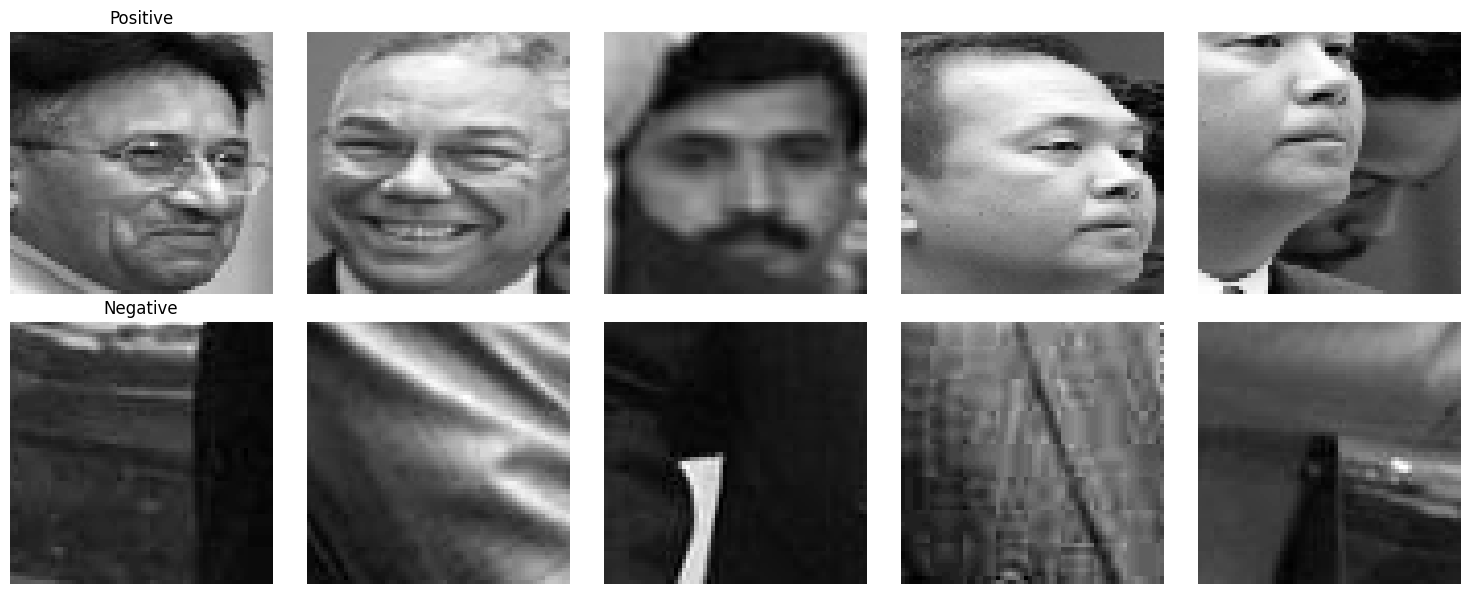

In [ ]:
def show_samples(pos, neg, n=5):
    # Check that there are at least n elements in both lists
    n = min(n, len(pos), len(neg))
    if n == 0:
        print("No images to display.")
        return

    plt.figure(figsize=(15, 6))

    for i in range(n):
        # Positive patches (first row)
        plt.subplot(2, n, i + 1)
        plt.imshow(pos[i], cmap='gray' if len(pos[i].shape) == 2 else None)
        if i == 0:
            plt.title("Positive")
        plt.axis("off")

        # Negative patches (second row)
        plt.subplot(2, n, i + 1 + n)
        plt.imshow(neg[i], cmap='gray' if len(neg[i].shape) == 2 else None)
        if i == 0:
            plt.title("Negative")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Example call:
show_samples(positive_patches, negative_patches, n=5)

##**Code Explanation – Visualizing Positive and Negative Patches:**
This code block helps you visually verify the patch extraction process from the dataset. It is an important step to ensure:
- Positive patches actually contain faces
- Negative patches do not include any facial regions

###**Key Actions:**
- Defines the show_samples() function which:
  1. Displays up to n positive patches in the first row
  2. Displays the same number of negative patches in the second row
  3. Uses imshow() with cmap='gray' for grayscale images, but adapts automatically if images are color
  4. Hides axes and labels for a clean presentation
  5. Uses tight_layout() to prevent overlapping elements in the figure.
- The function gracefully handles cases when there are fewer patches than requested or none at all by adjusting n and printing a message

###**Why This Step Matters:**
- Visual sanity check: Confirms the patches have been correctly extracted and labeled
- Debugging aid: Helps catch potential errors like empty patches, mislabeling, or accidental overlap in negative samples
- Quality assurance: Crucial before training machine learning models to ensure clean and accurate input data, preventing poor model performance due to bad data.

In [ ]:
# STEP 2 - HOG FEATURE EXTRACTION
def extract_hog_features(patches, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys'):
    """
    Extract HOG features from a list of images.

    Args:
        patches (list or array): list of image patches.
        orientations (int): number of orientation bins.
        pixels_per_cell (tuple): size (in pixels) of a cell.
        cells_per_block (tuple): number of cells in each block.
        block_norm (str): block normalization method.

    Returns:
        np.ndarray: feature matrix of shape (num_patches, num_features).
    """
    # Use list comprehension instead of append in a loop for better efficiency and readability
    features = [hog(patch,
                    orientations=orientations,
                    pixels_per_cell=pixels_per_cell,
                    cells_per_block=cells_per_block,
                    block_norm=block_norm,
                    visualize=False) for patch in patches]

    return np.array(features)

# Extract features
X_pos = extract_hog_features(positive_patches)
X_neg = extract_hog_features(negative_patches)

# Labels
y_pos = np.ones(len(X_pos))
y_neg = np.zeros(len(X_neg))

# Combine dataset
X = np.vstack([X_pos, X_neg])
y = np.hstack([y_pos, y_neg])

print("✅ Feature matrix shape:", X.shape)
print("✅ Labels shape:", y.shape)

✅ Feature matrix shape: (32327, 1764)
✅ Labels shape: (32327,)


##**Code Explanation – Step 2: HOG Feature Extraction**
This step converts grayscale image patches into structured numerical features using the Histogram of Oriented Gradients (HOG) descriptor. HOG is a classical and highly effective technique for object detection tasks, especially face detection, due to its ability to capture edge and shape information.

###**What’s Being Done**
HOG Feature Extraction:
- The function extract_hog_features() processes a list of grayscale image patches and returns an array of HOG feature vectors
- The extraction uses hog() from skimage.feature with the following parameters:
  1. orientations=9: Number of orientation bins used to quantize gradient directions
  2. pixels_per_cell=(8, 8): Size of each cell in pixels, setting the granularity of the local histograms
  3. cells_per_block=(2, 2): Context size used for local normalization (improves illumination invariance)
  4. block_norm='L2-Hys': Block normalization method that enhances robustness.

Application:
- Features are extracted for:
  1. positive_patches: Patches known to contain faces
  2. negative_patches: Patches sampled from non-face regions
- Each patch is converted into a fixed-length 1D feature vector describing edge orientations and structures

Label Assignment:
- Each face patch is assigned the label 1 (positive class)
- Each non-face patch is assigned the label 0 (negative class)

Dataset Assembly:
- Feature vectors for positive and negative samples (X_pos, X_neg) are stacked vertically into a single matrix X
- Corresponding labels (y_pos, y_neg) are concatenated into a single label array y

Verification:
- The final print statements display the shape of X and y, verifying how many samples and how many features per sample have been generated

###**Why This Step Is Important**
- Descriptive power: HOG captures local shape and structure, which are essential for distinguishing faces from the background
- Robustness: HOG features are more stable than raw pixel values across lighting changes, small shifts, and scale variations
- Compatibility: The resulting feature vectors are suitable for traditional machine learning models (e.g. LinearSVC, LogisticRegression in Scikit-learn)
- Efficiency: The use of list comprehension for HOG extraction improves performance and keeps the code compact and readable

In [ ]:
# Count and display the number of occurrences of each label in the array y
print(collections.Counter(y))

Counter({np.float64(0.0): 27275, np.float64(1.0): 5052})


##**Code Explanation – Label Distribution Check**
This short code block is used to verify the class balance in your dataset, which is crucial for training a reliable binary classifier.

###**What the Code Does**
- collections.Counter is used to count how many times each class label (0 = non-face, 1 = face) appears in the label array y
- The result is printed as a dictionary-like object, showing the total number of:
   1. Positive samples (faces)
   2. Negative samples (non-faces)

###**Why This Step Is Important**
- Ensures that the dataset is not severely imbalanced, which can negatively affect model performance
- A balanced dataset helps avoid bias where the model learns to predict only the majority class
- If the counts are very skewed, you might consider:
  1. Downsampling the majority class
  2. Using techniques like SMOTE (not ideal here due to image data)
  3. Adjusting class weights in the classifier

In [ ]:
# STEP 3 - TRAINING AND EVALUATING A FACE DETECTION CLASSIFIER USING SCIKIT-LEARN
# Split the dataset into training and test sets
# 80% of the data is used for training, 20% for testing
# random_state=0 ensures reproducibility of the split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# Print the number of training samples
print(f"Training samples: {len(X_train)}")

# Print the number of test samples
print(f"Test samples: {len(X_test)}")

Training samples: 25861
Test samples: 6466


##**Code Explanation – Step 3: Training and Evaluating a Face Detection Classifier using Scikit-learn**
This step divides your dataset into two parts: one for training your classifier, and one for evaluating its performance. This is a standard and essential step in any supervised machine learning project.

###**What This Code Does**
- train_test_split from Scikit-learn is used to randomly divide the full dataset (X, y) into:
  1. Training set (80%) → used to fit the model
  2. Test set (20%) → held out for evaluation
- random_state=0 is set to ensure reproducibility — the same split will be created every time you run the code
- It prints out the sizes of the training and test sets so you can verify that the split worked as expected

###**Why This Step Is Important**
- Prevents overfitting by testing the model on unseen data
- Gives you an unbiased estimate of how well your model will generalize to new images
- Ensures the training process is reproducible and controlled

In [ ]:
# Create a pipeline that first standardizes the features, then trains a linear SVM using SGD
clf = make_pipeline(
    StandardScaler(),  # Features standardization (zero mean, unit variance)
    SGDClassifier(loss='hinge', max_iter=1000, tol=1e-3, random_state=0, class_weight='balanced')  # Linear SVM with SGD optimizer
)

# Train the model using the training data
clf.fit(X_train, y_train)

# Predict labels for the training set
y_train_pred = clf.predict(X_train)

# Predict labels for the test set
y_test_pred = clf.predict(X_test)

# Print classification report for training data
print("\n Classification Report (Training Set):")
print(classification_report(y_train, y_train_pred))

# Print classification report for test data
print("\n Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred))


 Classification Report (Training Set):
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99     21819
         1.0       0.88      0.97      0.92      4042

    accuracy                           0.98     25861
   macro avg       0.94      0.97      0.95     25861
weighted avg       0.98      0.98      0.98     25861


 Classification Report (Test Set):
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98      5456
         1.0       0.85      0.92      0.88      1010

    accuracy                           0.96      6466
   macro avg       0.92      0.94      0.93      6466
weighted avg       0.96      0.96      0.96      6466



##**Code Explanation – Training a Linear SVM with SGD**
- Pipeline setup:
A pipeline is created where features are first normalized using StandardScaler (zero mean, unit variance), a crucial step for models like SVM to perform effectively.
- Classifier:
SGDClassifier is used with the 'hinge' loss function, which implements a linear Support Vector Machine (SVM). The class_weight='balanced' parameter handles the class imbalance by weighting classes inversely proportional to their frequency.
- Training and prediction:
The model is trained on the training data and predictions are made on both training and test sets for evaluation.
- Evaluation:
Classification reports provide precision, recall, F1-score, and accuracy for each class and overall, helping to analyze model performance and generalization.

###**Bibliographic Reference and Method Justification**
- The combination of Histogram of Oriented Gradients (HOG) features with Linear SVM classifiers is a classic and well-established approach in face detection and object recognition. This methodology was popularized by Dalal and Triggs (2005) in their seminal work on pedestrian detection, and has since been adapted successfully for face detection (see e.g. Dalal & Triggs, 2005, "Histograms of Oriented Gradients for Human Detection", CVPR)
- Why HOG + Linear SVM?
  1. HOG features effectively capture local shape and edge information, which are crucial for face structure representation
  2. Linear SVMs are fast to train and predict, especially with large-scale datasets
  3. The use of SGDClassifier to implement the linear SVM enables efficient incremental training and scalability on limited computational resources, aligning with the project constraints
- Why this combination fits the project specs:
  1. No pre-trained models are used: the model is trained from scratch on extracted HOG features, meeting the requirement of no pre-trained weights
  2. HOG + linear SVM keeps computational complexity low, suitable for resource-constrained environments
  3. The approach allows a clear, interpretable pipeline from raw images to bounding box detection via learned classification, facilitating explainability and optimization
  4. The class weighting within SGDClassifier addresses dataset imbalance, improving robustness

In [ ]:
def plot_confusion_matrix(y_true, y_pred, labels=["Negative", "Positive"], show_precision_recall=False):
    """
    Plot confusion matrix with optional precision and recall for positive class.

    Args:
        y_true: True labels
        y_pred: Predicted labels
        labels: List of class names (default ["Negative", "Positive"])
        show_precision_recall: If True, display precision and recall on the plot
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create a DataFrame for better visualization
    df_cm = pd.DataFrame(cm, index=labels,
                         columns=[f"Predicted {labels[0]}", f"Predicted {labels[1]}"])

    plt.figure(figsize=(6, 5))
    sns.heatmap(df_cm, annot=True, fmt="g", cmap="Blues")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.title("Confusion Matrix")

    # Show precision and recall for positive class if requested
    if show_precision_recall:
        # Avoid division by zero
        precision = cm[1,1] / (cm[1,1] + cm[0,1]) if (cm[1,1] + cm[0,1]) > 0 else 0
        recall = cm[1,1] / (cm[1,1] + cm[1,0]) if (cm[1,1] + cm[1,0]) > 0 else 0

        plt.text(0, -0.2, f"Precision: {precision:.2f}", fontsize=12, ha='left', va='center', transform=plt.gca().transAxes)
        plt.text(1, -0.2, f"Recall: {recall:.2f}", fontsize=12, ha='right', va='center', transform=plt.gca().transAxes)

    plt.show()

##**Code Explanation - plot_confusion_matrix**
This block defines a function to compute and visualize the confusion matrix, a key tool for evaluating classifier performance. The plot_confusion_matrix function:
- Takes true labels (y_true) and predicted labels (y_pred)
- Computes the confusion matrix using scikit-learn’s confusion_matrix
- Displays it as a heatmap using Seaborn for easy interpretation
- Optionally shows precision and recall for the positive class, important metrics especially in imbalanced classification tasks
- Allows customizable class labels (positive and negative)
- Helps identify types of classification errors (false positives and false negatives)

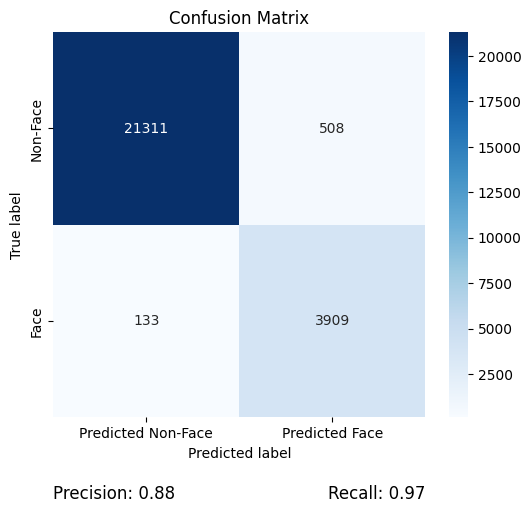

In [ ]:
# Plot the confusion matrix with precision and recall for the training set
plot_confusion_matrix(y_train, y_train_pred, labels=["Non-Face", "Face"], show_precision_recall=True)

##**What is a Confusion Matrix?**

A confusion matrix is a performance measurement tool for classification models. It is a table used to evaluate the accuracy of a classification algorithm by comparing the actual (true) values to the predicted values made by the model. This matrix helps to visualize the performance of the algorithm in a more detailed manner.

The confusion matrix is typically used for binary classification (i.e., when there are two classes), but it can be extended to multi-class classification as well.

##**Breakdown of Elements:**
- True Negative (TN): The number of times the model correctly predicted the negative class (i.e., the model predicted negative when the true class was also negative);

- False Positive (FP): The number of times the model incorrectly predicted the positive class (i.e., the model predicted positive when the true class was negative). This is also known as a "Type I error";

- False Negative (FN): The number of times the model incorrectly predicted the negative class (i.e., the model predicted negative when the true class was positive). This is also known as a "Type II error";

- True Positive (TP): The number of times the model correctly predicted the positive class (i.e., the model predicted positive when the true class was also positive).

##**Why Use a Confusion Matrix?**
- Balanced Evaluation:
  It allows you to evaluate your model beyond simple accuracy, which can be misleading in imbalanced datasets. For example, if the dataset has a very high number of negative samples (class imbalance), accuracy might be high simply because the model is predicting the majority class (negative) most of the time. However, precision, recall, and F1 score provide better insights into how well the model handles both classes;

- Performance Insights: The confusion matrix helps to directly see where the model is making errors (e.g., more false positives or false negatives), which allows you to focus on improving the model in specific areas.

##**Visualizing the Confusion Matrix with Precision and Recall**
In the function plot_confusion_matrix(y_true, y_pred, show_precision_recall=True), if show_precision_recall=True is passed, the function calculates the precision and recall values and places them on the confusion matrix visualization. This will help you understand at a glance how well your model is identifying both the positive and negative classes, along with these key metrics.

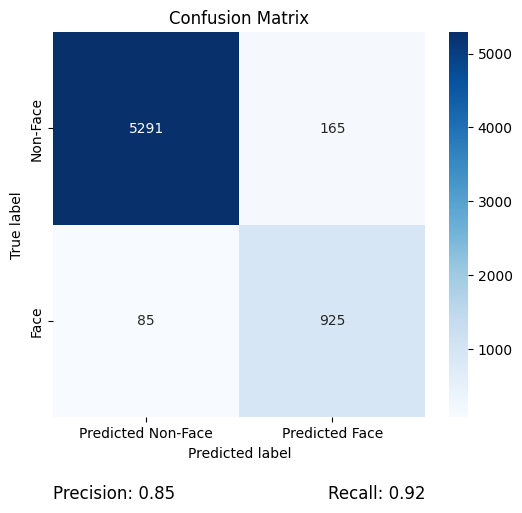

In [ ]:
# Same for the test set
plot_confusion_matrix(y_test, y_test_pred, labels=["Non-Face", "Face"], show_precision_recall=True)

# What we said previously for the confusion matrix (train set) also applies here for the test set

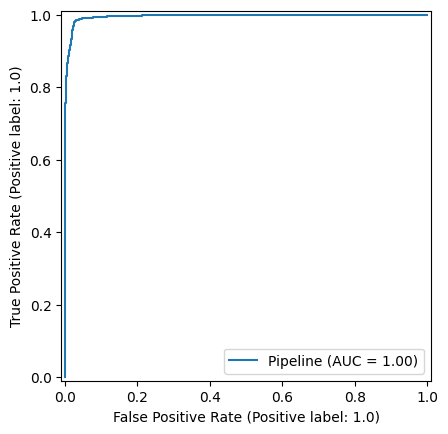

In [ ]:
# Plot the ROC (Receiver Operating Characteristic) curve using the training set
RocCurveDisplay.from_estimator(clf, X_train, y_train)

##**1. ROC Curve (Receiver Operating Characteristic Curve):**
The ROC curve is a graphical representation used to evaluate the performance of a classification model, particularly when the classes are imbalanced. It is primarily used in binary classification tasks (i.e., two classes: Positive and Negative). The curve plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various thresholds:

- True Positive Rate (TPR), also called Recall or Sensitivity, is the proportion of actual positives that are correctly identified as positive by the model;

- False Positive Rate (FPR) is the proportion of actual negatives that are incorrectly identified as positive by the model.

The ROC curve is a plot where:

- The x-axis represents the False Positive Rate (FPR);

- The y-axis represents the True Positive Rate (TPR).

Each point on the ROC curve corresponds to a different threshold value used for classification. By adjusting the threshold, you get different values of TPR and FPR, and these are plotted on the curve.

###**Key Features of the ROC Curve:**
- Diagonal Line (Random Classifier): The diagonal line (also called the line of no discrimination) represents the performance of a random classifier. A random classifier would have a 50% chance of correctly classifying a positive or negative instance, so the ROC curve would lie along this line. In practice, you want your model to perform better than this.

The higher the ROC curve, the better your model is at distinguishing between the positive and negative classes.

- Threshold Adjustment: As you move along the ROC curve, you're changing the decision threshold for classifying instances as positive or negative. Lowering the threshold increases the number of predicted positives, which tends to increase TPR but also increases FPR.

###**Interpreting the ROC Curve:**
- Closer to the top-left corner: A good model’s ROC curve should curve upwards towards the top-left corner of the plot. This indicates a high true positive rate and a low false positive rate, meaning the model is doing well at identifying positive instances and not misclassifying many negative ones;

- Closer to the diagonal line: If the ROC curve is closer to the diagonal, it indicates a model that is not doing much better than random guessing;

- Steep curve: A sharp rise to the top-left corner indicates that the model quickly starts identifying positives correctly without many false positives, which is ideal.

##**2. AUC (Area Under the Curve):**
AUC stands for Area Under the ROC Curve. It quantifies the overall performance of the model. AUC is a scalar value that tells us how well the model distinguishes between the classes.

AUC ranges from 0 to 1:

- AUC = 1: Perfect model. It perfectly separates positive and negative classes with no errors;

- AUC = 0.5: Random model. The model is no better than random guessing;

- AUC < 0.5: The model is performing worse than random guessing. This usually happens when the model is predicting the wrong class for almost all instances.

The AUC value gives you a measure of how much the model is capable of distinguishing between classes:

- AUC = 0.8-0.9: Good model;

- AUC = 0.7-0.8: Fair model;

- AUC = 0.6-0.7: Poor model;

- AUC < 0.6: Model has poor performance.

###**How to Interpret AUC:**
- High AUC (close to 1): A high AUC value indicates that the model has a strong ability to differentiate between the positive and negative classes. The higher the AUC, the better the model's predictive ability.

- Low AUC (close to 0.5): An AUC near 0.5 indicates that the model does not distinguish between the positive and negative classes any better than random chance.

- Very Low AUC (below 0.5): This could indicate that the model has serious issues, potentially learning the wrong patterns or being heavily biased in predicting the wrong class.

##**ROC Curve and AUC in Practice:**
In practice, both the ROC curve and AUC are especially useful in scenarios where there is a class imbalance (i.e., when one class is much more frequent than the other). In such cases, accuracy alone may not be a good metric for evaluating performance, as a model that predicts the majority class every time could still achieve high accuracy but perform poorly for the minority class.

ROC Curve helps to evaluate the trade-offs between True Positives and False Positives at different thresholds. It tells you how well your model performs for various thresholds and is particularly useful when you care about adjusting thresholds to optimize recall, precision, or any other specific metric.

AUC gives a single scalar value that summarizes the model's overall ability to discriminate between the positive and negative classes. This is especially helpful when you want to compare different models.

##**When to Use:**
ROC Curve is useful when you want to evaluate how well your model performs across all possible thresholds.

AUC is useful when you want a single value that summarizes your model’s ability to distinguish between classes.

In our case (predicting whether a customer will accept an offer or not), we have an AUC of 0.81 and the ROC curve is positioned in the top-left corner, this indicates that the model is performing quite well in distinguishing between the two classes (accepting the offer = Positive, not accepting the offer = Negative). We're talking about the train set.

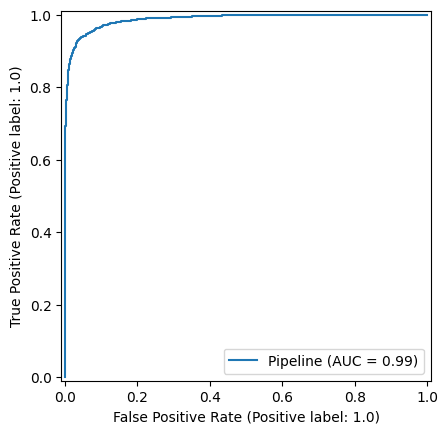

In [ ]:
# Same for test set
RocCurveDisplay.from_estimator(clf, X_test, y_test)

# What we said previously for the ROC Curve (train set) also applies here for the test set

In [ ]:
# Download an image from Unsplash and save it as 'test_face.jpg'
!curl -L -o test_face.jpg "https://images.unsplash.com/photo-1531746020798-e6953c6e8e04"

# Check that the file has been downloaded by listing files in the current directory
print("Files in the current directory:")
print(os.listdir())

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2513k  100 2513k    0     0  9649k      0 --:--:-- --:--:-- --:--:-- 9665k
Files in the current directory:
['.config', 'fddb_data', 'fddb-dataset.zip', 'test_face.jpg', 'sample_data']


This snippet downloads a sample image from Unsplash using curl and saves it locally as test_face.jpg. This image, which is free to use under Unsplash’s copyright-free license, can then be used to test the face detection pipeline you are building. After downloading, it lists the files in the current working directory to confirm that the image file was saved successfully.

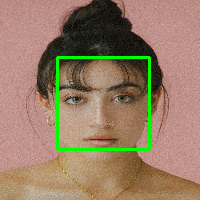

In [ ]:
# STEP 4: FACE DETECTION USING SLIDING WINDOW, MULTI-SCALE AND NMS
# Load image
image = cv2.imread('test_face.jpg')
image = cv2.resize(image, (200, 200))

# --- Detection utilities ---

def sliding_window(image, step_size, window_size):
    """
    Generator function to slide a window across the image.

    Args:
        image (ndarray): Input image.
        step_size (int): Number of pixels to skip horizontally and vertically.
        window_size (tuple): Width and height of the sliding window.

    Yields:
        Tuple (x, y, window): Top-left corner and the cropped window patch.
    """
    for y in range(0, image.shape[0] - window_size[1] + 1, step_size):
        for x in range(0, image.shape[1] - window_size[0] + 1, step_size):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

def pyramid(image, scale=1.2, min_size=(64, 64)):
    """
    Image pyramid generator to create scaled versions of the input image.

    Args:
        image (ndarray): Original input image.
        scale (float): Downscale factor for each layer.
        min_size (tuple): Minimum width and height to stop pyramid scaling.

    Yields:
        Scaled image at each pyramid level.
    """
    yield image
    while True:
        w = int(image.shape[1] / scale)
        h = int(image.shape[0] / scale)
        image = cv2.resize(image, (w, h))
        if image.shape[0] < min_size[1] or image.shape[1] < min_size[0]:
            break
        yield image

def non_max_suppression_with_scores(boxes, overlapThresh=0.3):
    """
    Applies Non-Maximum Suppression (NMS) to filter overlapping bounding boxes based on confidence scores.

    Args:
        boxes (list): List of bounding boxes with scores [x, y, w, h, score].
        overlapThresh (float): IoU threshold to consider a box redundant.

    Returns:
        list: Filtered list of boxes after applying NMS.
    """
    if len(boxes) == 0:
        return []

    boxes = np.array(boxes)
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 0] + boxes[:, 2]
    y2 = boxes[:, 1] + boxes[:, 3]
    scores = boxes[:, 4]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)

        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= overlapThresh)[0]
        order = order[inds + 1]

    return boxes[keep].astype(int).tolist()

def detect_faces(image, clf, window_size=(64, 64), step_size=20, pyramid_scale=1.2, threshold=0.9):
    """
    Perform face detection using sliding window, image pyramid and HOG features.

    Args:
        image (ndarray): Input image.
        clf (sklearn classifier): Trained classifier with decision_function.
        window_size (tuple): Size of sliding window (default is 64x64).
        step_size (int): Step size for sliding window.
        pyramid_scale (float): Scale factor for image pyramid.
        threshold (float): Confidence threshold for detection.

    Returns:
        list: Final list of bounding boxes after filtering and NMS.
    """
    detections = []
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    for resized in pyramid(gray, scale=pyramid_scale, min_size=window_size):
        scale_factor = gray.shape[1] / float(resized.shape[1])

        for (x, y, window) in sliding_window(resized, step_size, window_size):
            if window.shape[0] != window_size[1] or window.shape[1] != window_size[0]:
                continue

            features = hog(window,
                           orientations=9,
                           pixels_per_cell=(8, 8),
                           cells_per_block=(2, 2),
                           block_norm='L2-Hys',
                           visualize=False)
            features = features.reshape(1, -1)
            score = clf.decision_function(features)[0]

            if score > threshold:
                x_orig = int(x * scale_factor)
                y_orig = int(y * scale_factor)
                w_orig = int(window_size[0] * scale_factor)
                h_orig = int(window_size[1] * scale_factor)
                detections.append([x_orig, y_orig, w_orig, h_orig, score])

    # Filter out boxes that are too small or too large
    filtered_boxes = []
    for (x, y, w, h, score) in detections:
        if 40 <= w <= 150 and 40 <= h <= 150:
            filtered_boxes.append([x, y, w, h, score])

    # Apply Non-Maximum Suppression
    final_boxes = non_max_suppression_with_scores(filtered_boxes, overlapThresh=0.3)

    # Optionally, keep only the best-scoring box
    if len(final_boxes) > 0:
        final_boxes = [max(final_boxes, key=lambda b: b[4])]

    return final_boxes

boxes = detect_faces(image, clf, threshold=0.9)

# Draw detected bounding boxes
for (x, y, w, h, *_) in boxes:  # *score ignored in drawing
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Show result
cv2_imshow(image)

##**Code Explanation - Step 4: Face Detection using Sliding Window, Multi-scale and NMS**
This step implements a classical face detection pipeline using a sliding window, multi-scale image pyramid, and Non-Maximum Suppression (NMS), combined with a trained LinearSVC classifier on HOG features.

###**Key Components**
- Image Pyramid (pyramid function):
  1. This function generates progressively smaller versions of the input image
  2. It allows the detection system to identify faces of different sizes by scaling down the image, rather than resizing the window
  3. The pyramid scale factor is set to 1.1, and it stops when the image becomes smaller than the detection window (64x64)

- Sliding Window (sliding_window function):
  1. For each level of the image pyramid, a window of fixed size (64x64 pixels) is moved across the image
  2. The step size is set to 20 pixels to balance between detection accuracy and computational cost
  3. Each extracted window becomes a candidate region to check for a face

- HOG Feature Extraction + Classification (detect_faces function):
  1. Each window is converted to grayscale and its HOG features are extracted using the same parameters as during training
  2. The trained classifier (e.g., a LinearSVC) computes a confidence score using decision_function()
  3. Only windows with a score higher than the threshold (e.g., 0.9) are considered valid detections

- Filtering and NMS (non_max_suppression_with_scores):
  1. Detected bounding boxes are first filtered by size to eliminate unrealistically small or large regions
  2. NMS is applied to remove overlapping detections by retaining only the most confident ones
  3. Optionally, the box with the highest score can be kept as the final result, ideal for test/demo scenarios

###**Why This Step Matters**
- Robust face localization: Combines spatial scanning and scale normalization to detect faces of different sizes and positions
- Model-driven scoring: Uses the classifier’s decision confidence to filter weak detections
- NMS refines output: Removes redundant overlapping detections and improves precision
- Classic CV pipeline: Fully compatible with limited hardware—no deep learning or pre-trained models required

##**CONCLUSIONS:**
This project successfully demonstrates a classical approach to face detection by leveraging Histogram of Oriented Gradients (HOG) features combined with a linear Support Vector Machine (SVM) classifier. The implementation covers all essential steps, including data preprocessing, feature extraction, model training, evaluation, and practical face detection on real-world images using a sliding window and image pyramid technique. Additionally, non-maximum suppression was applied to refine detection results by removing redundant overlapping boxes.

Despite its simplicity compared to deep learning-based methods, this pipeline proves effective for controlled environments and offers valuable insights into traditional computer vision techniques. The modular design and clear evaluation metrics make it a solid foundation for further improvements, such as incorporating more sophisticated classifiers, data augmentation, or real-time detection capabilities.

Overall, the project highlights the practical utility of classical machine learning and image processing methods in face detection tasks and provides a strong baseline for future exploration.